# Multilayer Perception implemented in numpy

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import pandas as pd

/tmp/ipykernel_34758/671612114.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
x, y = fetch_openml('mnist_784', version=1, return_X_y=True, parser='auto')

In [3]:

DIMENSIONS = (28, 28)
CHANNELS = 1  # grayscale
INPUT_SIZE = DIMENSIONS[0] * DIMENSIONS[1]
OUTPUT_SIZE = 10

def transform_data(
        is_convolutional: bool,
        x: pd.DataFrame,
        y: pd.Series | None = None) -> tuple[np.array, np.array]:
    """
    Transforms the data. Returns a tuple of (x, y) where x is a tensor of the features and y is a
    tensor of the labels.

    Args:
        is_convolutional: A boolean indicating whether the model is convolutional.
        x: A dataframe of the features.
        y: A series of the labels.
    """
    x = x.to_numpy()
    # Normalize the tensor
    x_min = x.min()
    x_max = x.max()
    x = (x - x_min) / (x_max - x_min)
    assert x.min() == 0
    assert x.max() == 1
    if is_convolutional:
        # Reshape data to have channel dimension
        # MNIST images are 28x28, so we reshape them to [batch_size, 1, 28, 28]
        x = x.reshape(-1, CHANNELS, DIMENSIONS[0], DIMENSIONS[1])
    if y is not None:
        y = y.to_numpy().astype(int)
    return x, y


def get_data():  # noqa
    """Function is required by and called from `model_pipeline()`."""
    x, y = fetch_openml('mnist_784', version=1, return_X_y=True, parser='auto')
    x, y = transform_data(is_convolutional=False, x=x, y=y)
    # 80% train; 10% validation; 10% test
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)
    print(f"Training set  : X-{x_train.shape}, y-{y_train.shape}")
    print(f"Validation set: X-{x_val.shape}, y-{y_val.shape}")
    print(f"Test set      : X-{x_test.shape}, y-{y_test.shape}")
    return x_train, x_val, x_test, y_train, y_val, y_test

x_train, x_val, x_test, y_train, y_val, y_test = get_data()

Training set  : X-(56000, 784), y-(56000,)
Validation set: X-(7000, 784), y-(7000,)
Test set      : X-(7000, 784), y-(7000,)


In [4]:
x_train.shape

(56000, 784)

In [5]:
y.shape

(70000,)

In [6]:
y[0:10]

0    5
1    0
2    4
3    1
4    9
5    2
6    1
7    3
8    1
9    4
Name: class, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

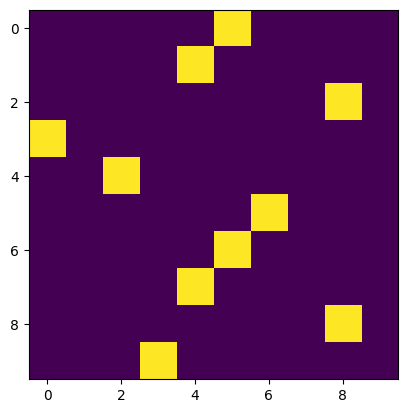

In [7]:
# encode
def one_hot_encode(index: int) -> np.array:
    """Return a one-hot encoded vector of the given index."""
    vector = np.zeros(OUTPUT_SIZE)
    vector[index] = 1
    return vector

y_train = np.array([one_hot_encode(i) for i in y_train])
y_val = np.array([one_hot_encode(i) for i in y_val])
y_test = np.array([one_hot_encode(i) for i in y_test])
plt.imshow(y_train[0:10])

In [16]:
def relu(z: np.array) -> np.array:
    """Return the ReLU of the input."""
    return np.maximum(0, z)

def relu_derivative(z: np.array) -> np.array:
    """Return the derivative of the ReLU of the input."""
    return (z > 0).astype(float)

def softmax(x: np.array) -> np.array:
    """
    Return the softmax of the input.

    The softmax function is a generalization of the logistic function that "squashes" a
    K-dimensional
    vector z of arbitrary real values to a K-dimensional vector sigma(z) of real values in the
    range (0, 1) that add up to 1.

    In other words, the softmax function transforms a vector of real values into a probability
    distribution.
    """
    exp_x = np.exp(x)
    return exp_x / exp_x.sum(axis=1).reshape(-1, 1)

def batch_norm_forward(Z, gamma, beta):
    """
    Perform batch normalization on the input Z (logits).

    Args:
        Z: input to the layer (logits)
        gamma: scale parameter
        beta: shift parameter
    """
    mu = np.mean(Z, axis=0)
    # mu.shape  # (100,) representing the 100 "input features" in this case 100 neurons
    var = np.var(Z, axis=0)
    # var.shape  # (100,) representing the 100 "input features" in this case 100 neurons
    epsilon = 1e-5
    # Z.shape  # (32, 100) representing the 32 samples (batch) and 100 neurons
    # so we are normalizing for each 100 neurons across the 32 samples
    Z_norm = (Z - mu) / np.sqrt(var + epsilon)
    # Z_norm.shape  # (32, 100) unchanged from Z
    # gamma.shape # (1, 100)
    # beta.shape  # (1, 100)
    # initially gamma and beta are 1 and 0 respectively
    # so the first time we run this function, Z_norm will be the same as Z
    # because we scale by 1 and shift by 0
    out = (gamma * Z_norm) + beta
    cache = (mu, var, Z, Z_norm, gamma, beta)
    return out, cache


def batch_norm_backward(dout, cache):
    """
    Calculate the gradients of the loss with respect to the parameters of the batch normalization
    layer.

    Args:
        dout: gradients of the loss with respect to the output of the batch normalization layer
        cache: contains the input to the layer, the normalized input, the scale and shift
        parameters, and the mean and variance of the input

    Returns:
        dZ: gradients of the loss with respect to the input to the batch normalization layer
        dgamma: gradients of the loss with respect to the scale parameter
        dbeta: gradients of the loss with respect to the shift parameter
    """
    mu, var, Z, Z_norm, gamma, _ = cache
    m = Z.shape[0]

    Z_mu = Z - mu
    std_inv = 1. / np.sqrt(var + 1e-8)

    dZ_norm = dout * gamma
    dvar = np.sum(dZ_norm * Z_mu, axis=0) * -.5 * std_inv**3
    dmu = np.sum(dZ_norm * -std_inv, axis=0) + dvar * np.mean(-2. * Z_mu, axis=0)

    dZ = (dZ_norm * std_inv) + (dvar * 2 * Z_mu / m) + (dmu / m)
    dgamma = np.sum(dout * Z_norm, axis=0)
    dbeta = np.sum(dout, axis=0)

    return dZ, dgamma, dbeta


def forward_pass(x: np.array, params: dict) -> tuple[np.array, dict]:
    """
    Return the output of a forward pass through the network, as well as the cache.

    The cache contains the pre-activations and activations for each layer.
    """
    # first hidden layer
    W_1 = params["W_1"]
    # bias term not used in batch normalization
    # b_1 = params["b_1"]
    # batch normalization
    bn_gamma_1 = params["bn_gamma_1"]
    bn_beta_1 = params["bn_beta_1"]
    # output layer
    W_2 = params["W_2"]
    b_2 = params["b_2"]

    # forward pass
    # Z is refered to as "logits"
    Z_1 = x @ W_1  # pre-activations for layer 1
    Z_1_bn, cache_bn_1 = batch_norm_forward(Z_1, bn_gamma_1, bn_beta_1)
    A_1 = relu(Z_1_bn)  # activations for layer 1

    Z_2 = (A_1 @ W_2) + b_2  # pre-activations for layer 2
    A_2 = softmax(Z_2)  # activations for layer 2 are probabilities

    cache = {
        "Z_1": Z_1,
        "A_1": A_1,
        # cache for batch normalization layer 1
        # i.e. cache = (mu, var, Z, Z_norm, gamma, beta) from above
        "bn1": cache_bn_1,
        "Z_2": Z_2,
        "A_2": A_2,
    }
    return A_2, cache

def backward_pass(x: np.array, y: np.array, params: dict, cache: dict) -> dict:
    """
    Return the gradients of the loss w.r.t. the parameters of the network.

    We need the gradients of the loss w.r.t. the parameters in order to update the parameters.

    The parameters are: W_1, b_1, W_2, b_2.

    The gradients are computed using backpropagation.
    """
    m = x.shape[0]
    A_1 = cache["A_1"]
    cache_bn1 = cache["bn1"]
    A_2 = cache["A_2"]  # Assuming this was stored during the forward pass

    # Gradient of the loss w.r.t. the softmax output (assuming y is one-hot encoded)
    dZ_2 = A_2 - y
    dW_2 = A_1.T @ dZ_2 / m
    db_2 = np.sum(dZ_2, axis=0, keepdims=True) / m
    # Backpropagation through the second layer to the first ReLU activation
    dA_1 = dZ_2 @ params["W_2"].T
    # Now we backpropagate through the batch normalization layer
    dZ_1_bn = dA_1 * relu_derivative(cache_bn1[3])  # Using Z_norm from the cache
    dZ_1, dgamma_1, dbeta_1 = batch_norm_backward(dZ_1_bn, cache_bn1)
    # Finally, compute gradients for the first layer weights
    dW_1 = x.T @ dZ_1 / m
    # Package gradients in a dictionary
    grads = {
        "dW_1": dW_1,
        "dgamma_1": dgamma_1,
        "dbeta_1": dbeta_1,
        "dW_2": dW_2,
        "db_2": db_2,
    }
    return grads

def update_parameters(params, grads, learning_rate):
    params['W_1'] -= learning_rate * grads['dW_1']
    # params['b_1'] -= learning_rate * grads['db_1']
    params['bn_gamma_1'] -= learning_rate * grads['dgamma_1']
    params['bn_beta_1'] -= learning_rate * grads['dbeta_1']
    params['W_2'] -= learning_rate * grads['dW_2']
    params['b_2'] -= learning_rate * grads['db_2']
    return params

def compute_loss(pred_probs: np.array, y: np.array) -> float:
    row_indices = np.arange(y.shape[0])
    column_indices = np.argmax(y, axis=1)
    pred_prob_of_actual = pred_probs[row_indices, column_indices]
    return -np.log(pred_prob_of_actual + 1e-9).mean()

In [17]:
seed = 42
rng = np.random.default_rng(seed)

input_size = 28 * 28
hidden_size = 100
output_size = 10

# He initialization for first weights (with ReLU activation)
he_scale = np.sqrt(2 / input_size)
# Glorot initialization for second weights (with softmax activation)
glorot_scale = np.sqrt(2 / (hidden_size + output_size))

# weights for hidden layer
W_1 = rng.normal(loc=0, scale=he_scale, size=(input_size, hidden_size))
# we don't need a bias term for batch normalization
# b_1 = np.zeros((1, hidden_size))

# batch_normalization
bn_gamma_1 = np.ones((1, hidden_size))
bn_beta_1 = np.zeros((1, hidden_size))

# weights for output layer
W_2 = rng.normal(loc=0, scale=glorot_scale, size=(hidden_size, output_size))
b_2 = np.zeros((1, output_size))

# I want to view the original weights vs trained weights
W_1_copy = W_1.copy()
W_2_copy = W_2.copy()

print(W_1.shape)
# print(b_1.shape)
print(W_2.shape)
print(b_2.shape)

(784, 100)
(100, 10)
(1, 10)


In [18]:
learning_rate = 0.01
epochs = 15
batch_size = 32
losses = []
val_losses = []

params = {
    "W_1": W_1,
    # "b_1": b_1,
    "bn_gamma_1": bn_gamma_1,
    "bn_beta_1": bn_beta_1,
    "W_2": W_2,
    "b_2": b_2,
}

# shuffle the training data
shuffle_index = rng.permutation(x_train.shape[0])
x_train, y_train = x_train[shuffle_index], y_train[shuffle_index]

start = time.time()
for epoch in range(epochs):
    for batch, i in enumerate(range(0, x_train.shape[0], batch_size)):
        x_batch = x_train[i:i+batch_size]
        y = y_train[i:i+batch_size]
        A2, cache = forward_pass(x_batch, params)
        loss = compute_loss(y=y, pred_probs=A2)
        grads = backward_pass(x_batch, y, params, cache)
        params = update_parameters(params, grads, learning_rate)
        if batch % 400 == 0:
            losses.append(loss)
            # calculate validation loss
            val_outputs, _ = forward_pass(x_val, params)
            val_loss = compute_loss(y=y_val, pred_probs=val_outputs)
            val_losses.append(val_loss)
            print(f"Epoch {epoch}, Batch {batch:04}, training loss {loss.round(3)}, validation loss {val_loss.round(3)}")  # noqa
end = time.time()

In [14]:
print(f"Training took {end - start:.2f} seconds")

Training took 30.02 seconds


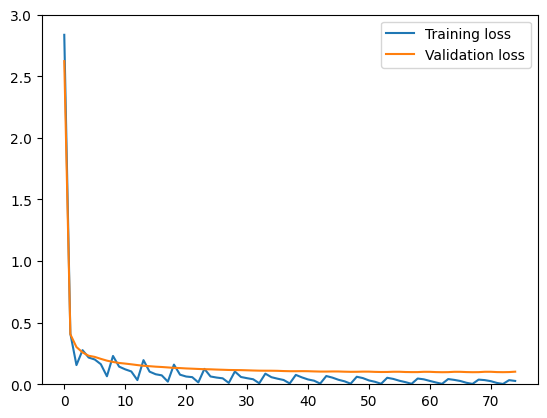

In [15]:
# plot losses over time
plt.plot(losses, label="Training loss")
plt.plot(val_losses, label="Validation loss")
plt.ylim(0, 3)
plt.legend()

In [ ]:
# plt.imshow(W_1)
# plt.show()
# plt.imshow(W_2)
# plt.show()

In [ ]:
# plt.imshow(W_1_copy)
# plt.show()
# plt.imshow(W_2_copy)
# plt.show()

In [ ]:
# test the model
A2, _ = forward_pass(x_test, params)
loss = compute_loss(A2, y_test)
print(f"Test loss: {loss}")

# make predictions
predictions = np.argmax(A2, axis=1)
actual = np.argmax(y_test, axis=1)
accuracy = (predictions == actual).mean()
print(f"Test accuracy: {accuracy}")

In [ ]:
print(predictions[0:20])
print(actual[0:20])

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(actual, predictions)
# remove the diagonal values (correct predictions) for better visualization
np.fill_diagonal(cm, 0)
fig = plt.figure(figsize=(OUTPUT_SIZE, OUTPUT_SIZE))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Count of Misclassified Samples by Class')